<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/PART_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [![DOI](https://zenodo.org/badge/357586333.svg)](https://zenodo.org/badge/latestdoi/357586333) -->

Change DOI HERE

#**PART II**

Part II of code for *Patterns of Intra-Seasonal Groundwater Recharge Inferred from Streamflow and Explained by Vadose Zone Storage Deficits*.

---



**Load packages.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime
import requests
import os
import json
import urllib
import warnings
from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.collections import LineCollection
matplotlib_axes_logger.setLevel('ERROR')
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
%config InlineBackend.figure_format = 'retina'

**Mount Google Drive.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  To mount Drive, find the file name of the folder you wish to connect to.  By default, files are saved to user's "My Drive" dashboard.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)  # Change folder name here

Mounted at /content/drive


**Load data.**  Load filtered catchment data (output of *Filter Catchments, Calculate Recharge and the Root-Zone Storage Deficit*) and attributes (output of *Summary of Catchment Hydrogeology*) from Google Drive.

In [ ]:
# Connect to folder created in "PART I"
path = "/content/drive/My Drive/recharge_deficit/"

# Catchment data
df_gages = pd.read_csv(path + "filtered_catchment_data.csv")
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)
df_gages = df_gages.loc['2000-10-01':'2020-10-01']

# Catchment attributes
df_attr = pd.read_csv(path + "catchment_attributes.csv")
df_attr.set_index('USGS Gage ID',inplace=True,drop=True)
df_attr.index = df_attr.index.astype('str')

#**1. Modified seasonal mass-balance at each catchment**

**Helper functions.**

In [ ]:
def first_rainfall(df):
  """Find the datetime of the first storm event occuring after the start
  of the precipitation time series.  Return DataFrame after first rainfall.

  Parameters
  ----------
  df : DataFrame with np.datetime64 index containing precipitation time series (column name = 'ppt') in mm.

  Returns
  ----------
  df : DataFrame containing data after first rainfall.
  """
  first_rain = df.loc[df['ppt']>=2].index[0]
  lag = pd.Timedelta(days=2)
  while first_rain <= df.index[0]+lag:
    df = df[first_rain+lag:]
    first_rain = df.loc[df['ppt']>=2].index[0]
  return df[first_rain:]

def nse(simulations, evaluation):
    """Nash-Sutcliffe Efficiency (NSE) following Nash and Sutcliffe (1970).

    Parameters
    ----------
    simulations : 1xn array containing simulated (modelled) data
    evaluation : 1xn array containing observed data

    Returns
    ----------
    nse_val : Value of the NSE.
    """
    numerator = np.sum((evaluation - simulations)**2)
    denominator = np.sum((evaluation - np.mean(evaluation))**2)
    nse_val = 1 - numerator / denominator
    return nse_val

**$Q_{wy}$ vs. $P_{wy}$ and $P_{wy} - D_{\textrm{first rain}}$.**

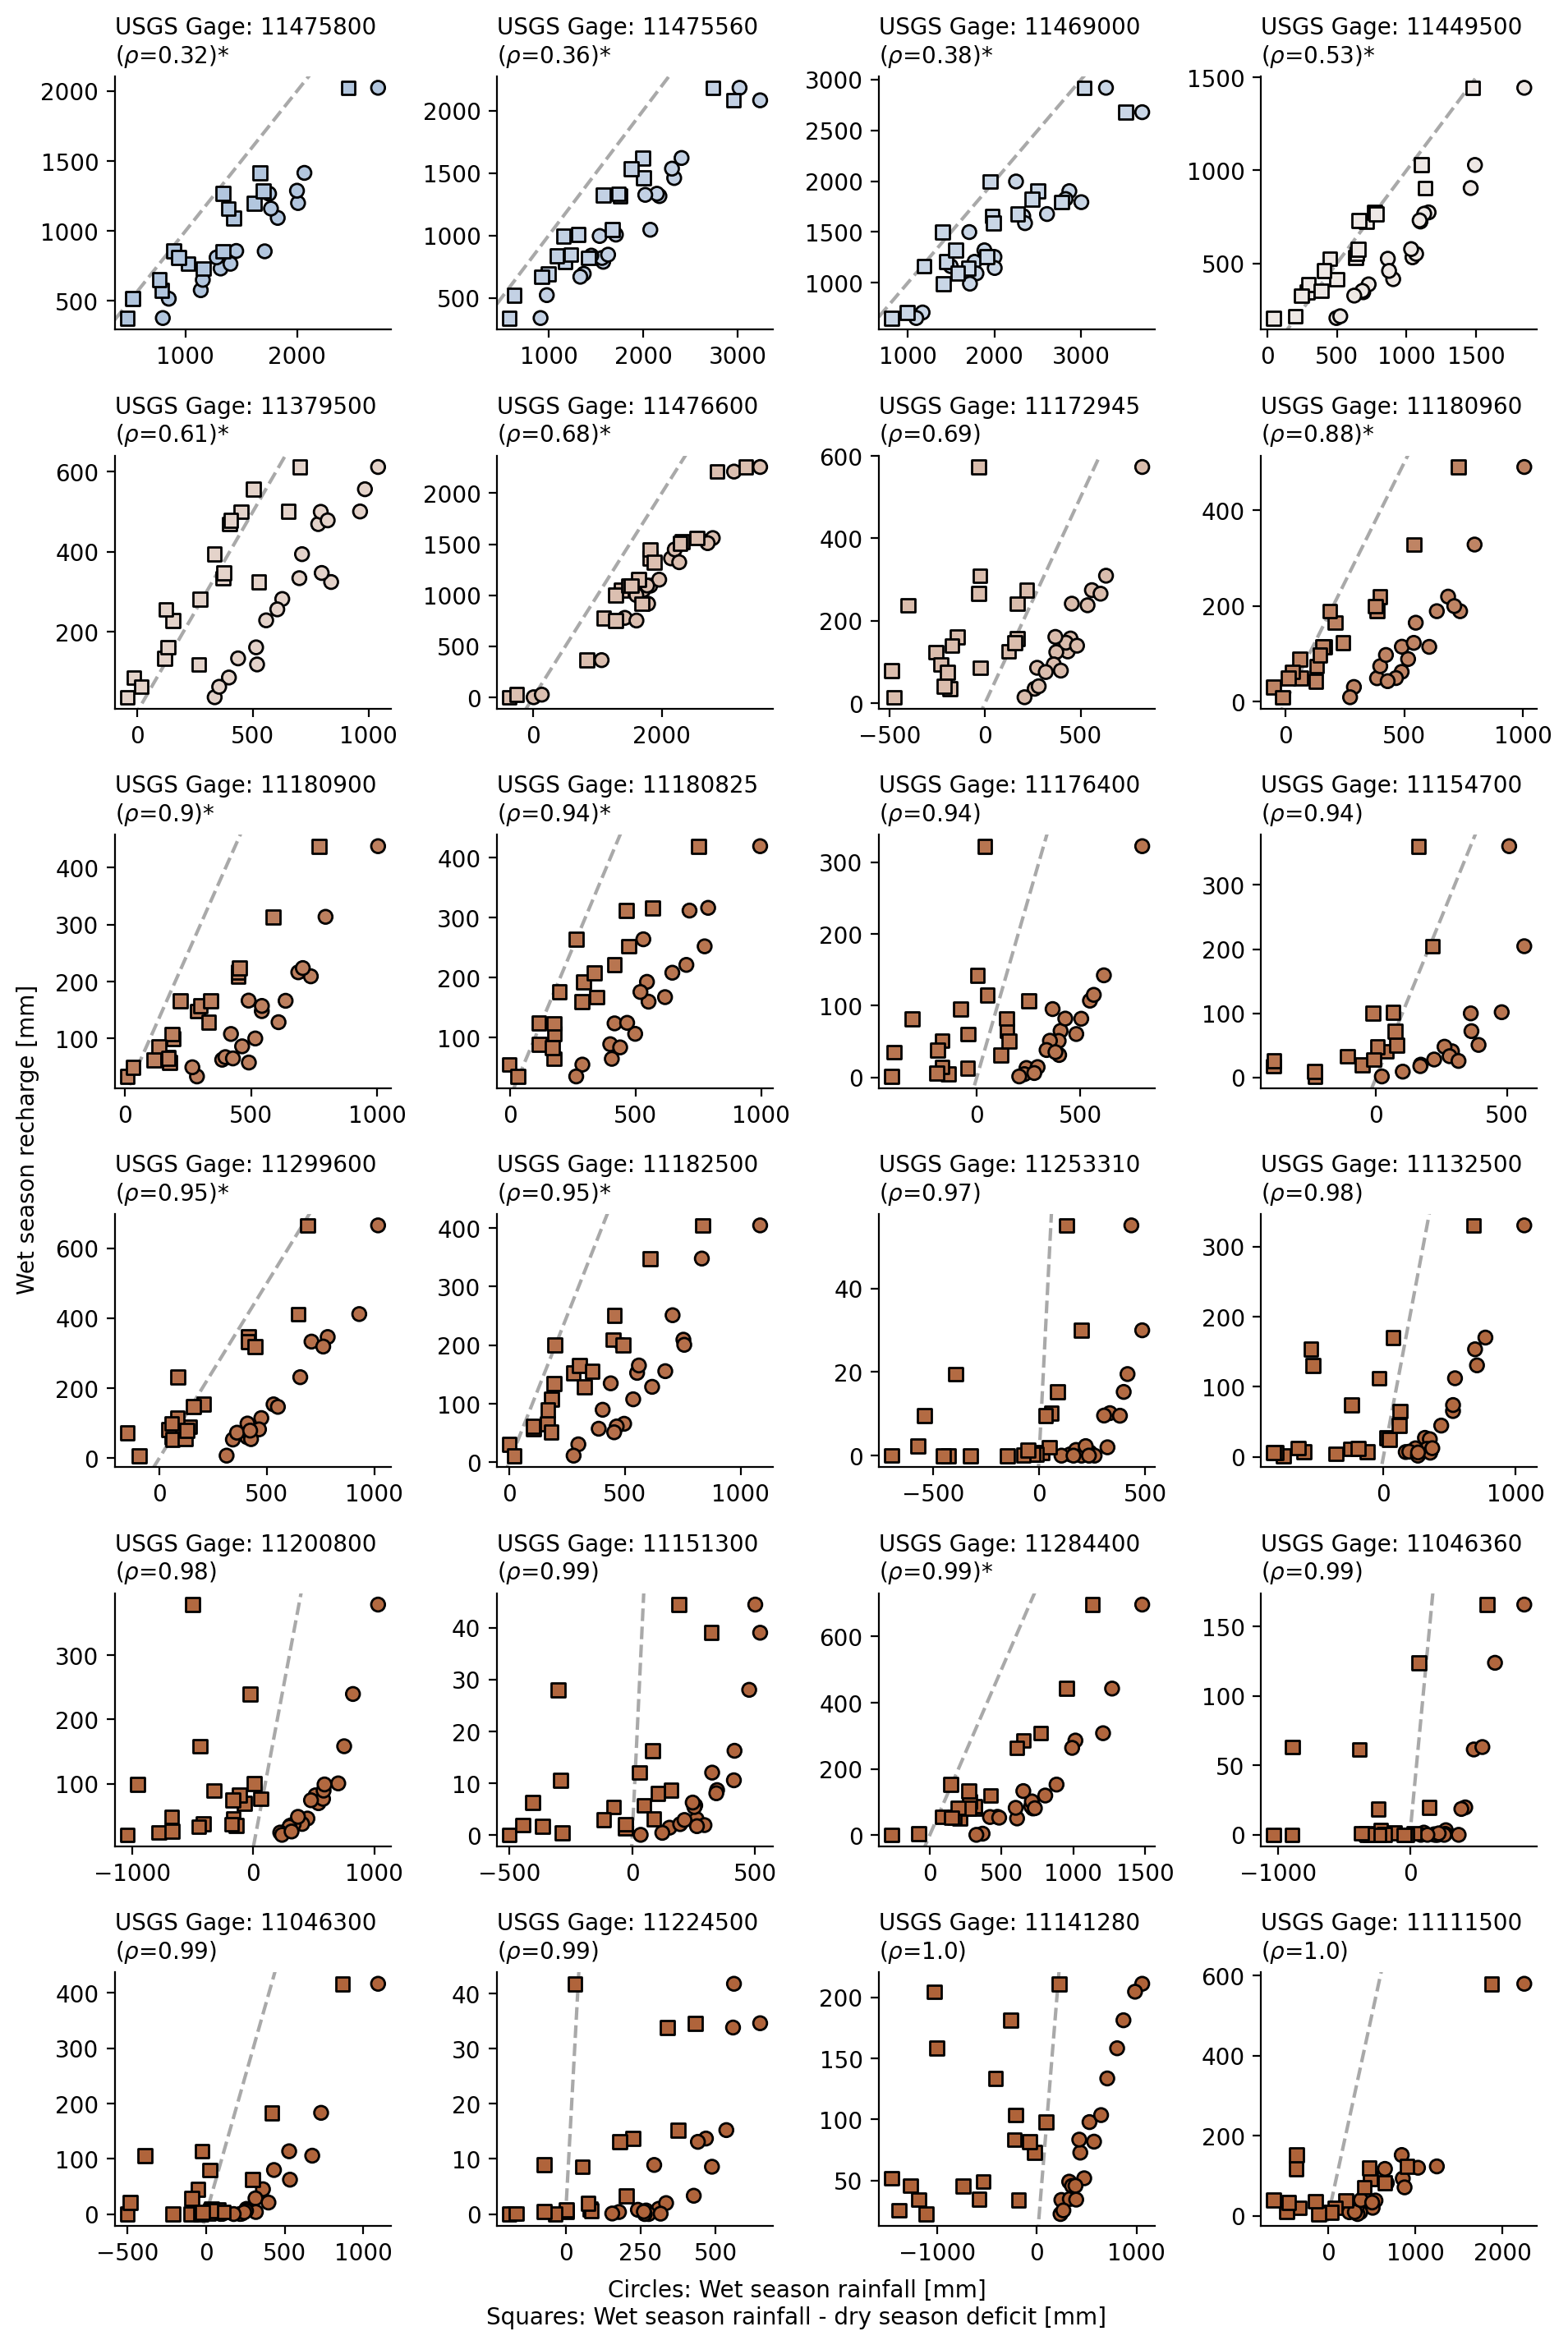

In [ ]:
# Unique gage IDs in DataFrame
gage_list = df_attr.sort_values(by='Storage sensitivity to winter precipitation (rho)',ascending=True).index

# Plotting space
fig, axs = plt.subplots(6,4,figsize=(9.5,14))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Run through gages
analysis_gages = np.array([])
for gage, ax in zip(gage_list,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  # Identify winter hydrology, wateryears
  winter_months = [10,11,12,1,2,3]
  df_gage = df_gage[df_gage.index.month.isin(winter_months)]
  wateryears = df_gage.wateryear.unique()
  x1 = np.array([])
  x2 = np.array([])
  y = np.array([])
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = df.D.iloc[0]
    x1 = np.append(x1,df.ppt.sum())
    x2 = np.append(x2,df.ppt.sum()-df.D.iloc[0])
    y = np.append(y,df.rt.sum())
  ax.scatter(x1,y,c=[rho]*len(x1),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.scatter(x2,y,c=[rho]*len(x2),ec='k',marker='s',cmap=cmap,vmin=0,vmax=1)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Identify watersheds without a runaway deficit
  if len(x2[x2<0])<5:
    analysis_gages = np.append(analysis_gages,gage)
    title = title+"*"
  ax.set(xlabel=None,ylabel=None)
  ax.set_title(title,loc='left',fontsize=10)

# Label, legend, figure handling
fig.text(0.5, -0.015, "Circles: Wet season rainfall [mm]\nSquares: Wet season rainfall - dry season deficit [mm]", ha='center')
fig.text(0, 0.5, "Wet season recharge [mm]", va='center', rotation='vertical')

fig.tight_layout()
sns.despine()

**Cumulative water year mass-balance.**

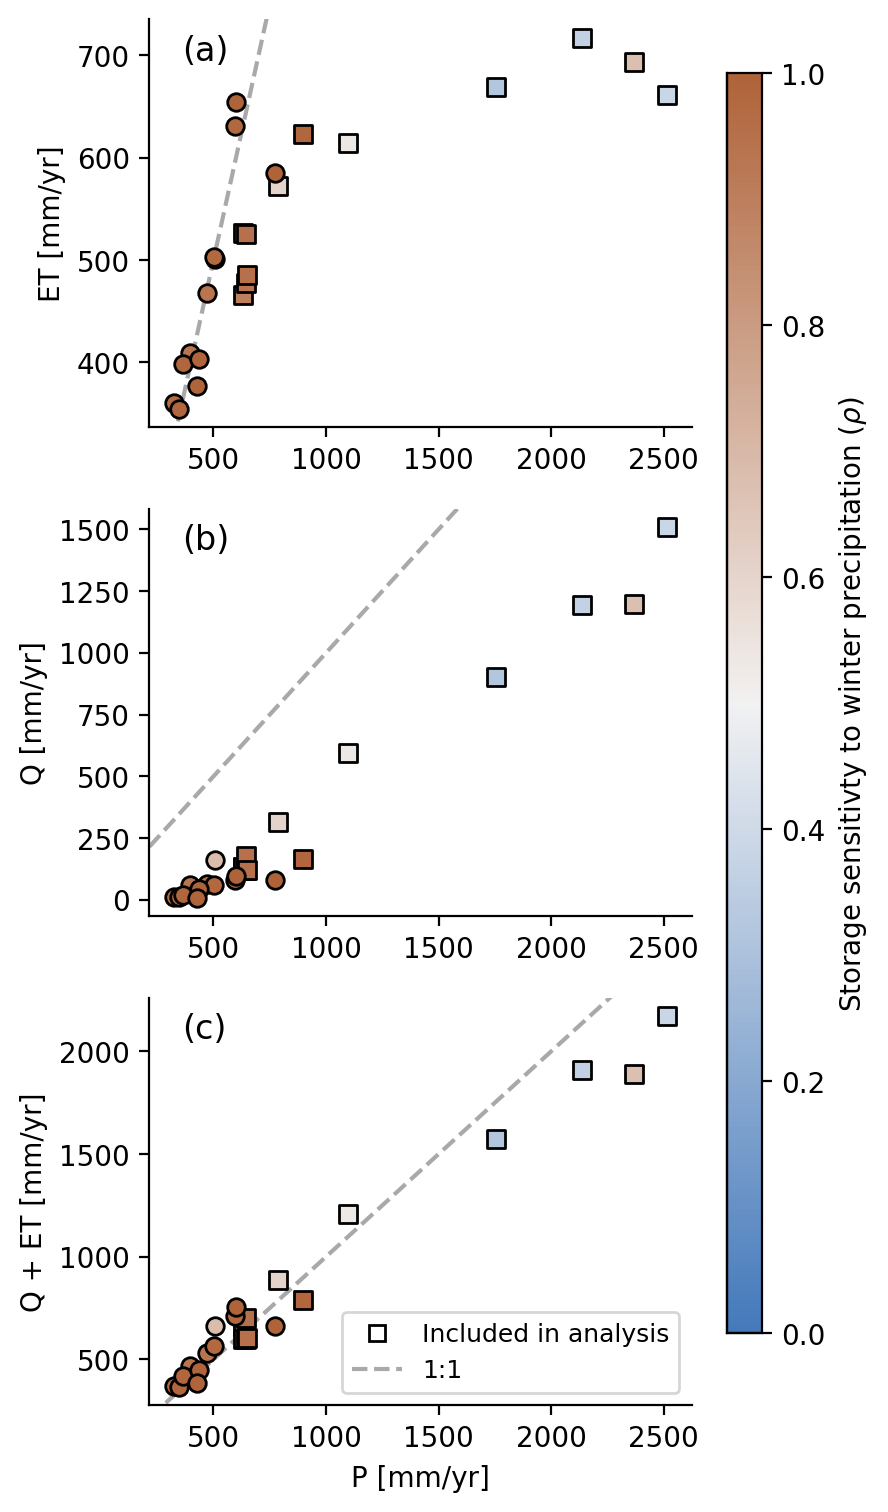

In [ ]:
# Plotting space, color map
fig,axs = plt.subplots(3,1,figsize=(3.5,9))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# List of gages classified as storage-capcity limited (Hahm et al., 2022)
scl_gages = ['11475560','11475800','11469000','11449500','11379500','11476600']

# Sum timeseries of complete fluxes for each gage, append to array
ppt_sum = np.array([])
et_sum = np.array([])
q_sum = np.array([])
color = np.array([])
marker = np.array([])
for gage in gage_list:
  # Plotting color based on limitation
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  color = np.append(color,rho)
  # Marker based on whether gage is included in analysis
  marker = np.append(marker,'s') if gage in analysis_gages else np.append(marker,'o')
  # Filter by gage
  df_gage_sum = df_gages.filter(regex=".*%s"%gage).dropna().sum()
  num_years = len(df_gages.filter(regex=".*%s"%gage).dropna())/365
  ppt_sum = np.append(ppt_sum,df_gage_sum['ppt_'+gage]/num_years)
  et_sum = np.append(et_sum,df_gage_sum['et_'+gage]/num_years)
  q_sum = np.append(q_sum,df_gage_sum['q_'+gage]/num_years)

# Plot raw data
kwargs = {'s':40,'ec':'k'}
for i in range(len(gage_list)):
  data = axs[0].scatter(ppt_sum[i], et_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. ET
  axs[1].scatter(ppt_sum[i], q_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. Q
  axs[2].scatter(ppt_sum[i], et_sum[i]+q_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. Q + ET

# 1:1 line
for ax in axs:
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Colorbar
cbar_ax = fig.add_axes([0.95,0.15,0.05,0.7])
axcb = fig.colorbar(data,cax=cbar_ax)
axcb.set_label(r'Storage sensitivty to winter precipitation ($\rho$)')
data.set_clim(0,1)

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label="Included in analysis"),
                  #  Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='o',ls='',label="Extracted Basin"),
                   Line2D([0],[0],color='darkgray',ls='--',label="1:1")]
axs[2].legend(handles=legend_elements,loc='lower right',fontsize=9)

# Text
axs[0].annotate('(a)', (.06,.9), xycoords= 'axes fraction', fontsize=12)
axs[1].annotate('(b)', (.06,.9), xycoords= 'axes fraction', fontsize=12)
axs[2].annotate('(c)', (.06,.9), xycoords= 'axes fraction', fontsize=12)

# Axis handling, despine
axs[0].set(ylabel="ET [mm/yr]")
axs[1].set(ylabel="Q [mm/yr]")
axs[2].set(xlabel="P [mm/yr]",ylabel="Q + ET [mm/yr]")
sns.despine()

**Plot $Q_{wy}$ vs. $P_{wy}$ and $P_{wy} - D_{\textrm{first rain}}$ for those catchments without a runaway deficit.**  

Define catchments with a runaway deficit where ($P_{wy} - D_{\textrm{first rain}}) <0$ for at least 5 years.

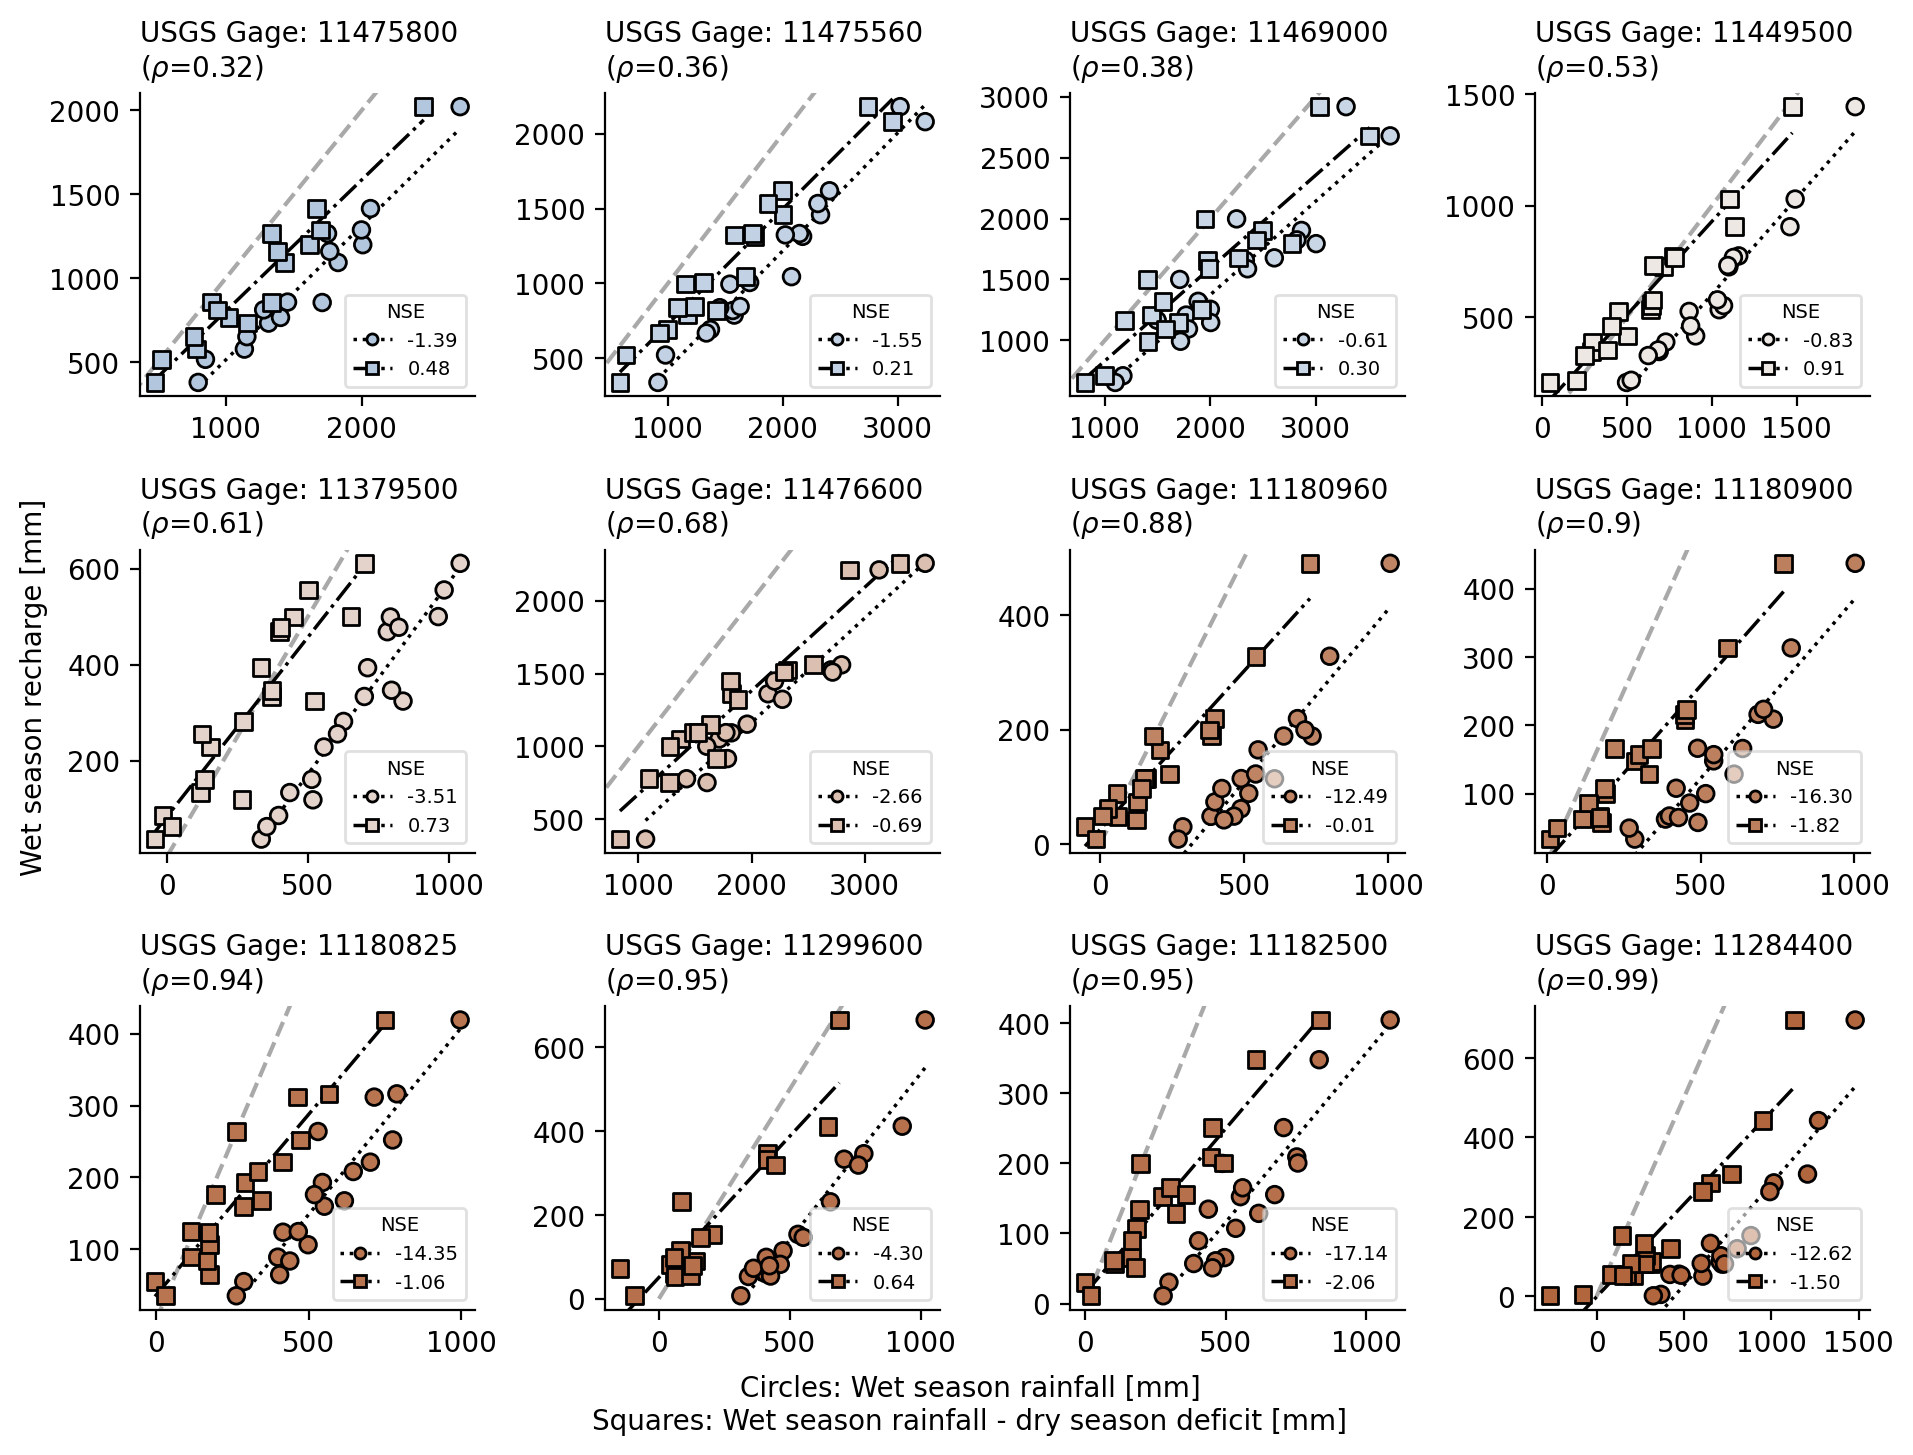

In [ ]:
# Plotting space
fig, axs = plt.subplots(3,4,figsize=(9.5,7))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Cumulative recharge vs. cumulative precipitation
for gage, ax in zip(analysis_gages,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  # Identify winter hydrology, wateryears
  winter_months = [10,11,12,1,2,3]
  df_gage = df_gage[df_gage.index.month.isin(winter_months)]
  wateryears = df_gage.wateryear.unique()
  x1 = np.array([])
  x2 = np.array([])
  deficit = np.array([])
  y = np.array([])
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = np.append(deficit,df.D.iloc[0])
    # Check wateryear length
    if len(df)<100: continue
    # Append
    x1 = np.append(x1,df.ppt.sum())
    x2 = np.append(x2,df.ppt.sum()-df.D.iloc[0])
    y = np.append(y,df.rt.sum())
  ax.scatter(x1,y,c=[rho]*len(x1),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.scatter(x2,y,c=[rho]*len(x2),ec='k',marker='s',cmap=cmap,vmin=0,vmax=1)
  ax.set_title(title,loc='left',fontsize=10)

  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([0,xmax],[0,xmax], c='darkgray', ls='--', zorder=-2)

  # 1:1 line R vs. P
  p1 = np.polyfit(x1,y,deg=1)
  xfit = np.linspace(min(x1),max(x1),50)
  yfit = p1[1]+p1[0]*xfit
  ax.plot(xfit, yfit, c='k', ls=':', lw=1.25, zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

  # 1:1 line R vs P-D
  p2 = np.polyfit(x2,y,deg=1)
  xfit = np.linspace(min(x2),max(x2),50)
  yfit = p2[1]+p2[0]*xfit
  ax.plot(xfit, yfit, c='k', ls='-.', lw=1.25, zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

  # Custom legend
  legend_elements = [matplotlib.lines.Line2D([],[], marker='o', markerfacecolor=cmap(rho), markeredgecolor='k', markersize=4, color='k', ls=':', lw=1.25, label=r"%.2f"%nse(x1,y)),
                     matplotlib.lines.Line2D([],[], marker='s', markerfacecolor=cmap(rho), markeredgecolor='k', markersize=4, color='k', ls='-.', lw=1.25, label=r"%.2f"%nse(x2,y))]
  ax.legend(handles=legend_elements,title='NSE',title_fontsize=7,loc='lower right',fontsize=7,framealpha=0.6)

# Label, legend, figure handling
fig.text(0.5, -0.03, "Circles: Wet season rainfall [mm]\nSquares: Wet season rainfall - dry season deficit [mm]", ha='center')
fig.text(0, 0.5, "Wet season recharge [mm]", va='center', rotation='vertical')
fig.tight_layout()
sns.despine()

#**2. Recharge in the first 500 mm of precipitation, moderated by deficit**

Plot the cumulative recharge generated by the first 500 mm of precipitation vs. the maximum deficit at the start of the water year.  Fit a linear regression to those catchments with at least 5 wateryears where the cumulative precipitation exceeds 500 mm.

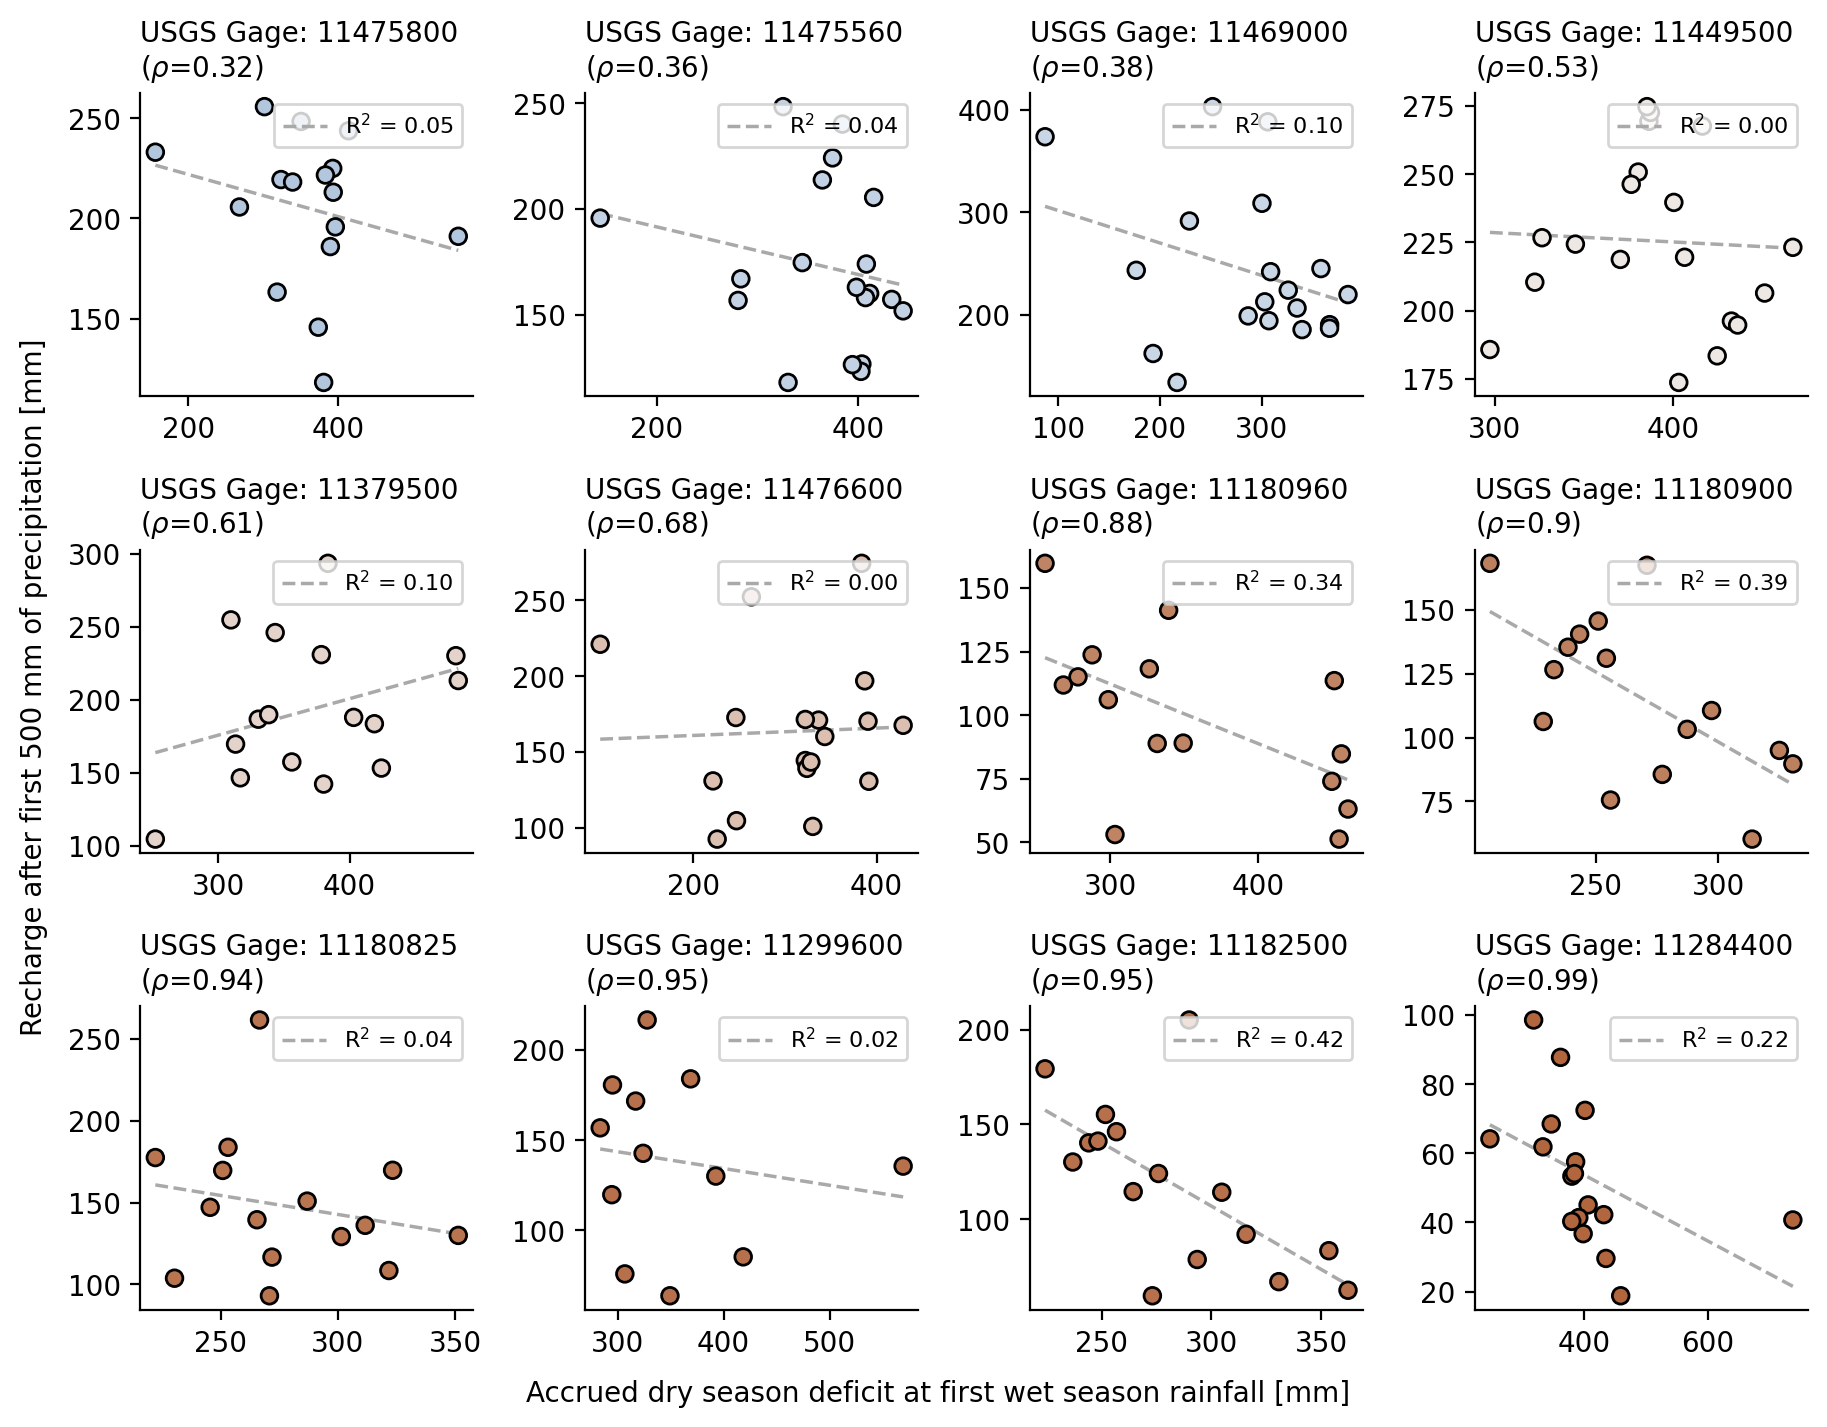

In [ ]:
# Plotting space
fig, axs = plt.subplots(3,4,figsize=(9,7))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Plot cumulative recharge v.s. precipitation for each catchment
for gage, ax in zip(analysis_gages,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  wateryears = df_gage.wateryear.unique()

  # Mean annual cumulative precipitation
  mean_annual_ppt = np.nanmean(df_gage.groupby('wateryear').ppt.cumsum().mean())
  threshold = 500 #(mm)
  xdata = np.array([])
  ydata = np.array([])
  n=0
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = df.D.iloc[0]
    # Recharge up to threshold of cumulative precipitation
    threshold_ppt = df.loc[df.ppt.cumsum()>=threshold].index
    if len(threshold_ppt)>0:
      df = df[df.ppt.cumsum()<=threshold]
      n+=1
    else: continue
    xdata = np.append(xdata,deficit)
    ydata = np.append(ydata,df.rt.cumsum().values[-1])
  ax.scatter(xdata,ydata,c=[rho]*len(xdata),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.set_title(title,loc='left',fontsize=10)

  # Fit all wateryears with linear regression & plot
  if n>=5:
    p = np.polyfit(xdata,ydata,deg=1)
    coefficient_of_determination = r2_score(ydata,p[1]+p[0]*xdata)
    xfit = np.linspace(min(xdata),max(xdata),50)
    yfit = p[1]+p[0]*xfit
    ax.plot(xfit, yfit, label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, c='darkgray', ls='--', lw=1.25, zorder=-2)
    ax.legend(loc='upper right',fontsize=8)

# Label handling
fig.text(0.5, -0.01, 'Accrued dry season deficit at first wet season rainfall [mm]', ha='center')
fig.text(-0.01, 0.5, 'Recharge after first 500 mm of precipitation [mm]', va='center', rotation='vertical')

# Figure appearance
fig.tight_layout()
sns.despine()

#**3. Storm-event analysis**

**Show method of identifying storm events.**

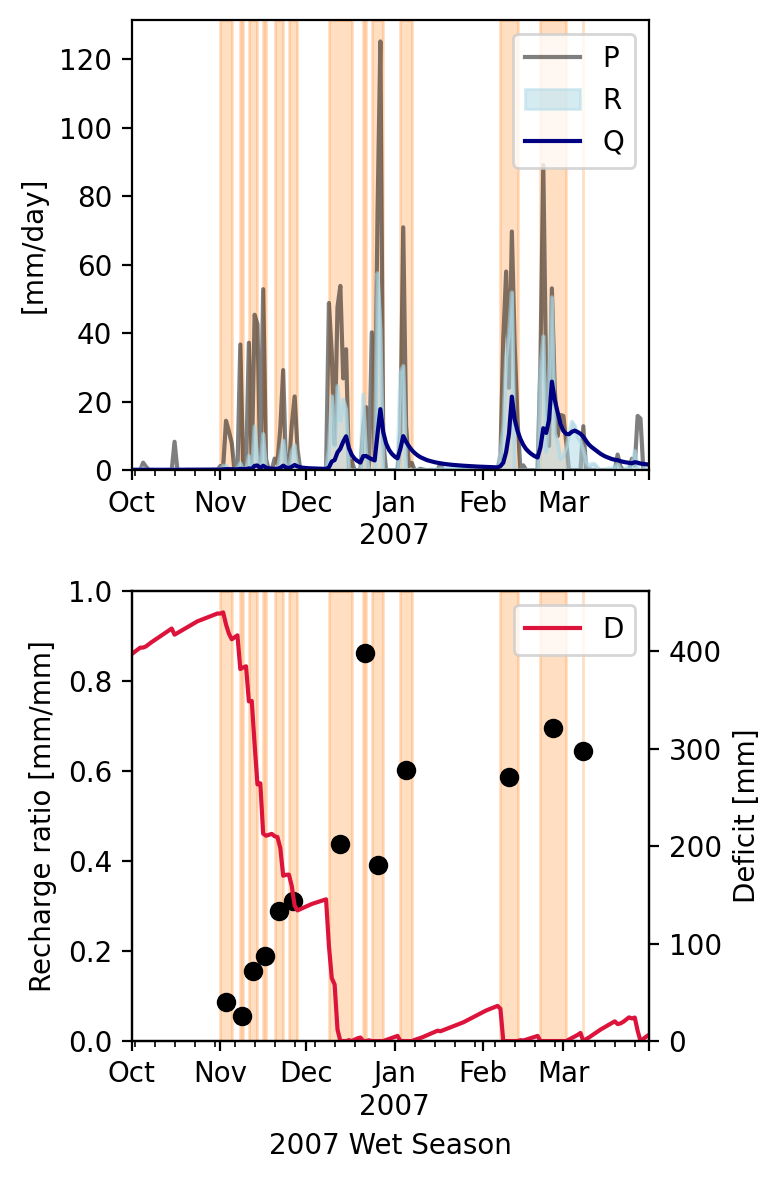

In [ ]:
# Define gage, wateryear
gage = '11475560'
wateryear = 2007

# Plotting space
fig, axs = plt.subplots(2,1,figsize=(4,6))

# Define gage data
df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']])
df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
df_gage.set_index('date', inplace=True)
df_gage.index = pd.to_datetime(df_gage.index)

# Identify winter hydrology, water year
winter_months = [10,11,12,1,2,3]
df_winter = df_gage[df_gage.index.month.isin(winter_months)]
df_wy = df_winter[df_winter['wateryear']==wateryear]

# Plot winter discharge, precipitation, recharge
df_wy.plot(y='ppt', label='P', color='k', alpha=0.5, ax=axs[0], zorder=-2)
df_wy.plot(y='rt', label='R', kind='area', color='lightblue', alpha=0.5, ax=axs[0], zorder=-1)
df_wy.plot(y='q', label='Q', color='navy', ax=axs[0], zorder=0)
axs[0].legend(loc='upper right')

# Plot deficit
twinx = axs[1].axes.twinx()
df_wy.plot(y='D', label='D', color='crimson', ax=twinx, zorder=0)
twinx.set_ylim(bottom=0)

# Identify storm periods
rainfall = df_wy.loc[df_wy.ppt>0].index
days_between_events = np.diff(rainfall)/np.timedelta64(1, 'D')
groups = np.split(rainfall, np.where(days_between_events>1.0)[0]+1)
rainfall_events_test = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]
rainfall_events = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]

# Exclude storm events with a total storm volume less than 10 mm
event_precip = np.array([df_wy.loc[event[0]:event[1]].ppt.sum() for event in rainfall_events])
event_precip_test = np.array([df_wy.loc[event[0]:event[1]].ppt.sum() for event in rainfall_events])
idx = [i for i in range(len(rainfall_events)) if event_precip[i] >= 10]
rainfall_events = [rainfall_events[i] for i in idx]

# Check for 2-day gap between rainfall events
inter_storm = np.array([(rainfall_events[i+1][0] - rainfall_events[i][1])/np.timedelta64(1,'D')-1 for i in range(len(rainfall_events)-1)])
rainfall_events = [rainfall_events[0]]+[i for i,j in zip(rainfall_events[1:],inter_storm) if j>=1.0]

# Remove storms lasting longer than 10 days
event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') + 1 for rain_event in rainfall_events])
idx = [i for i in range(len(rainfall_events)) if event_length[i] <= 10]
rainfall_events = [rainfall_events[i] for i in idx]

# Calculate fluxes from event
event_precip = np.array([df_wy.loc[rain_event[0]:rain_event[1]].ppt.sum() for rain_event in rainfall_events])
event_recharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]+np.timedelta64(1,'D')].rt.sum() for rain_event in rainfall_events]) # add day here to account for recharge lag
event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') + 1 for rain_event in rainfall_events])
event_deficit = np.array([df_wy.loc[rain_event[0]].D for rain_event in rainfall_events])
event_ratio = event_recharge/event_precip

# Plot storm periods
middle_of_storm = np.array([])
for event in rainfall_events:
  middle_of_storm = np.append(middle_of_storm,event[0]+(event[1]-event[0])/2)
  axs[0].axvspan(event[0],event[1],alpha=0.25,color='tab:orange',zorder=-4)
  axs[1].axvspan(event[0],event[1],alpha=0.25,color='tab:orange',zorder=-4)

# Plot
axs[1].scatter(middle_of_storm,event_ratio,c='k',label='Event recharge ratio')

# Axis handling
axs[0].set(xlabel="",ylabel="[mm/day]")
axs[1].set(xlabel="%s Wet Season"%str(wateryear),ylabel="Recharge ratio [mm/mm]",ylim=[0,1])
twinx.set(ylabel="Deficit [mm]")

# Layout
fig.tight_layout()

**Define helper function.**

In [ ]:
def storm_event_analysis(df_gages,gage):
  """Storm-event analysis of the interrelation between recharge, precipitation,
  and the root-zone storage deficit.

  Parameters
  ----------
  df_gages: DataFrame containing combined gage data for all study catchments
  gage: USGS gage ID corresponding to catchment (str)
  ----------
  Returns
  ----------
  precip (:obj:`array`): Event precipitation (mm)
  recharge (:obj:`array`): Event recharge (mm)
  deficit (:obj:`array`): Deficit at the start of event (mm)
  length(:obj:`array`): Length of the storm event (days)
  """
  # Filter combined dataframe to single gage
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)

  # Identify water years containing >90% data
  wateryears = np.unique(df_gage.wateryear.values)
  wateryear_length = df_gage.dropna().groupby('wateryear').size()
  complete_wateryears = wateryear_length[wateryear_length>324].index.values

  # Arrays to store storm-event recharge ratio, deficit, and storm volume
  precip = np.array([])
  recharge = np.array([])
  discharge = np.array([])
  deficit = np.array([])
  length = np.array([])

  # Identify storm events
  for wateryear in complete_wateryears:
    # Skip first water year, do not exceed 2020 water year
    if wateryear in [2001,2021]: continue
    # Start water year on first rainfall event occuring after Oct. 1st
    df_wy = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    # Identify storm periods
    rainfall = df_wy.loc[df_wy.ppt>0].index
    days_between_events = np.diff(rainfall)/np.timedelta64(1, 'D')
    groups = np.split(rainfall, np.where(days_between_events>1.0)[0]+1)
    rainfall_events = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]
    # Exclude storm events with a total storm volume less than 10 mm
    event_precip = np.array([df_wy.loc[event[0]:event[1]].ppt.sum() for event in rainfall_events])
    idx = [i for i in range(len(rainfall_events)) if event_precip[i] >= 10]
    rainfall_events = [rainfall_events[i] for i in idx]
    # Check for 2-day gap between rainfall events
    inter_storm = np.array([(rainfall_events[i+1][0] - rainfall_events[i][1])/np.timedelta64(1,'D') for i in range(len(rainfall_events)-1)])
    rainfall_events = [rainfall_events[0]]+[i for i,j in zip(rainfall_events[1:],inter_storm) if j>=2.0]
    # Remove storms lasting longer than 10 days
    event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') + 1 for rain_event in rainfall_events])
    idx = [i for i in range(len(rainfall_events)) if event_length[i] <= 10]
    rainfall_events = [rainfall_events[i] for i in idx]
    # Calculate fluxes from event
    event_precip = np.array([df_wy.loc[rain_event[0]:rain_event[1]].ppt.sum() for rain_event in rainfall_events])
    event_recharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]+np.timedelta64(1,'D')].rt.sum() for rain_event in rainfall_events]) # add day here to account for recharge lag
    event_discharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]].q.sum() for rain_event in rainfall_events])
    event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') + 1 for rain_event in rainfall_events])
    # Identify deficit at start of rainfall periods
    event_deficit = np.array([df_wy.loc[rain_event[0]].D for rain_event in rainfall_events])
    # Append to DataFrame
    precip = np.append(precip,event_precip)
    recharge = np.append(recharge,event_recharge)
    discharge = np.append(discharge,event_discharge)
    deficit = np.append(deficit,event_deficit)
    length = np.append(length,event_length)

  return precip, recharge, discharge, deficit, length

**Event precipitation vs. recharge.**

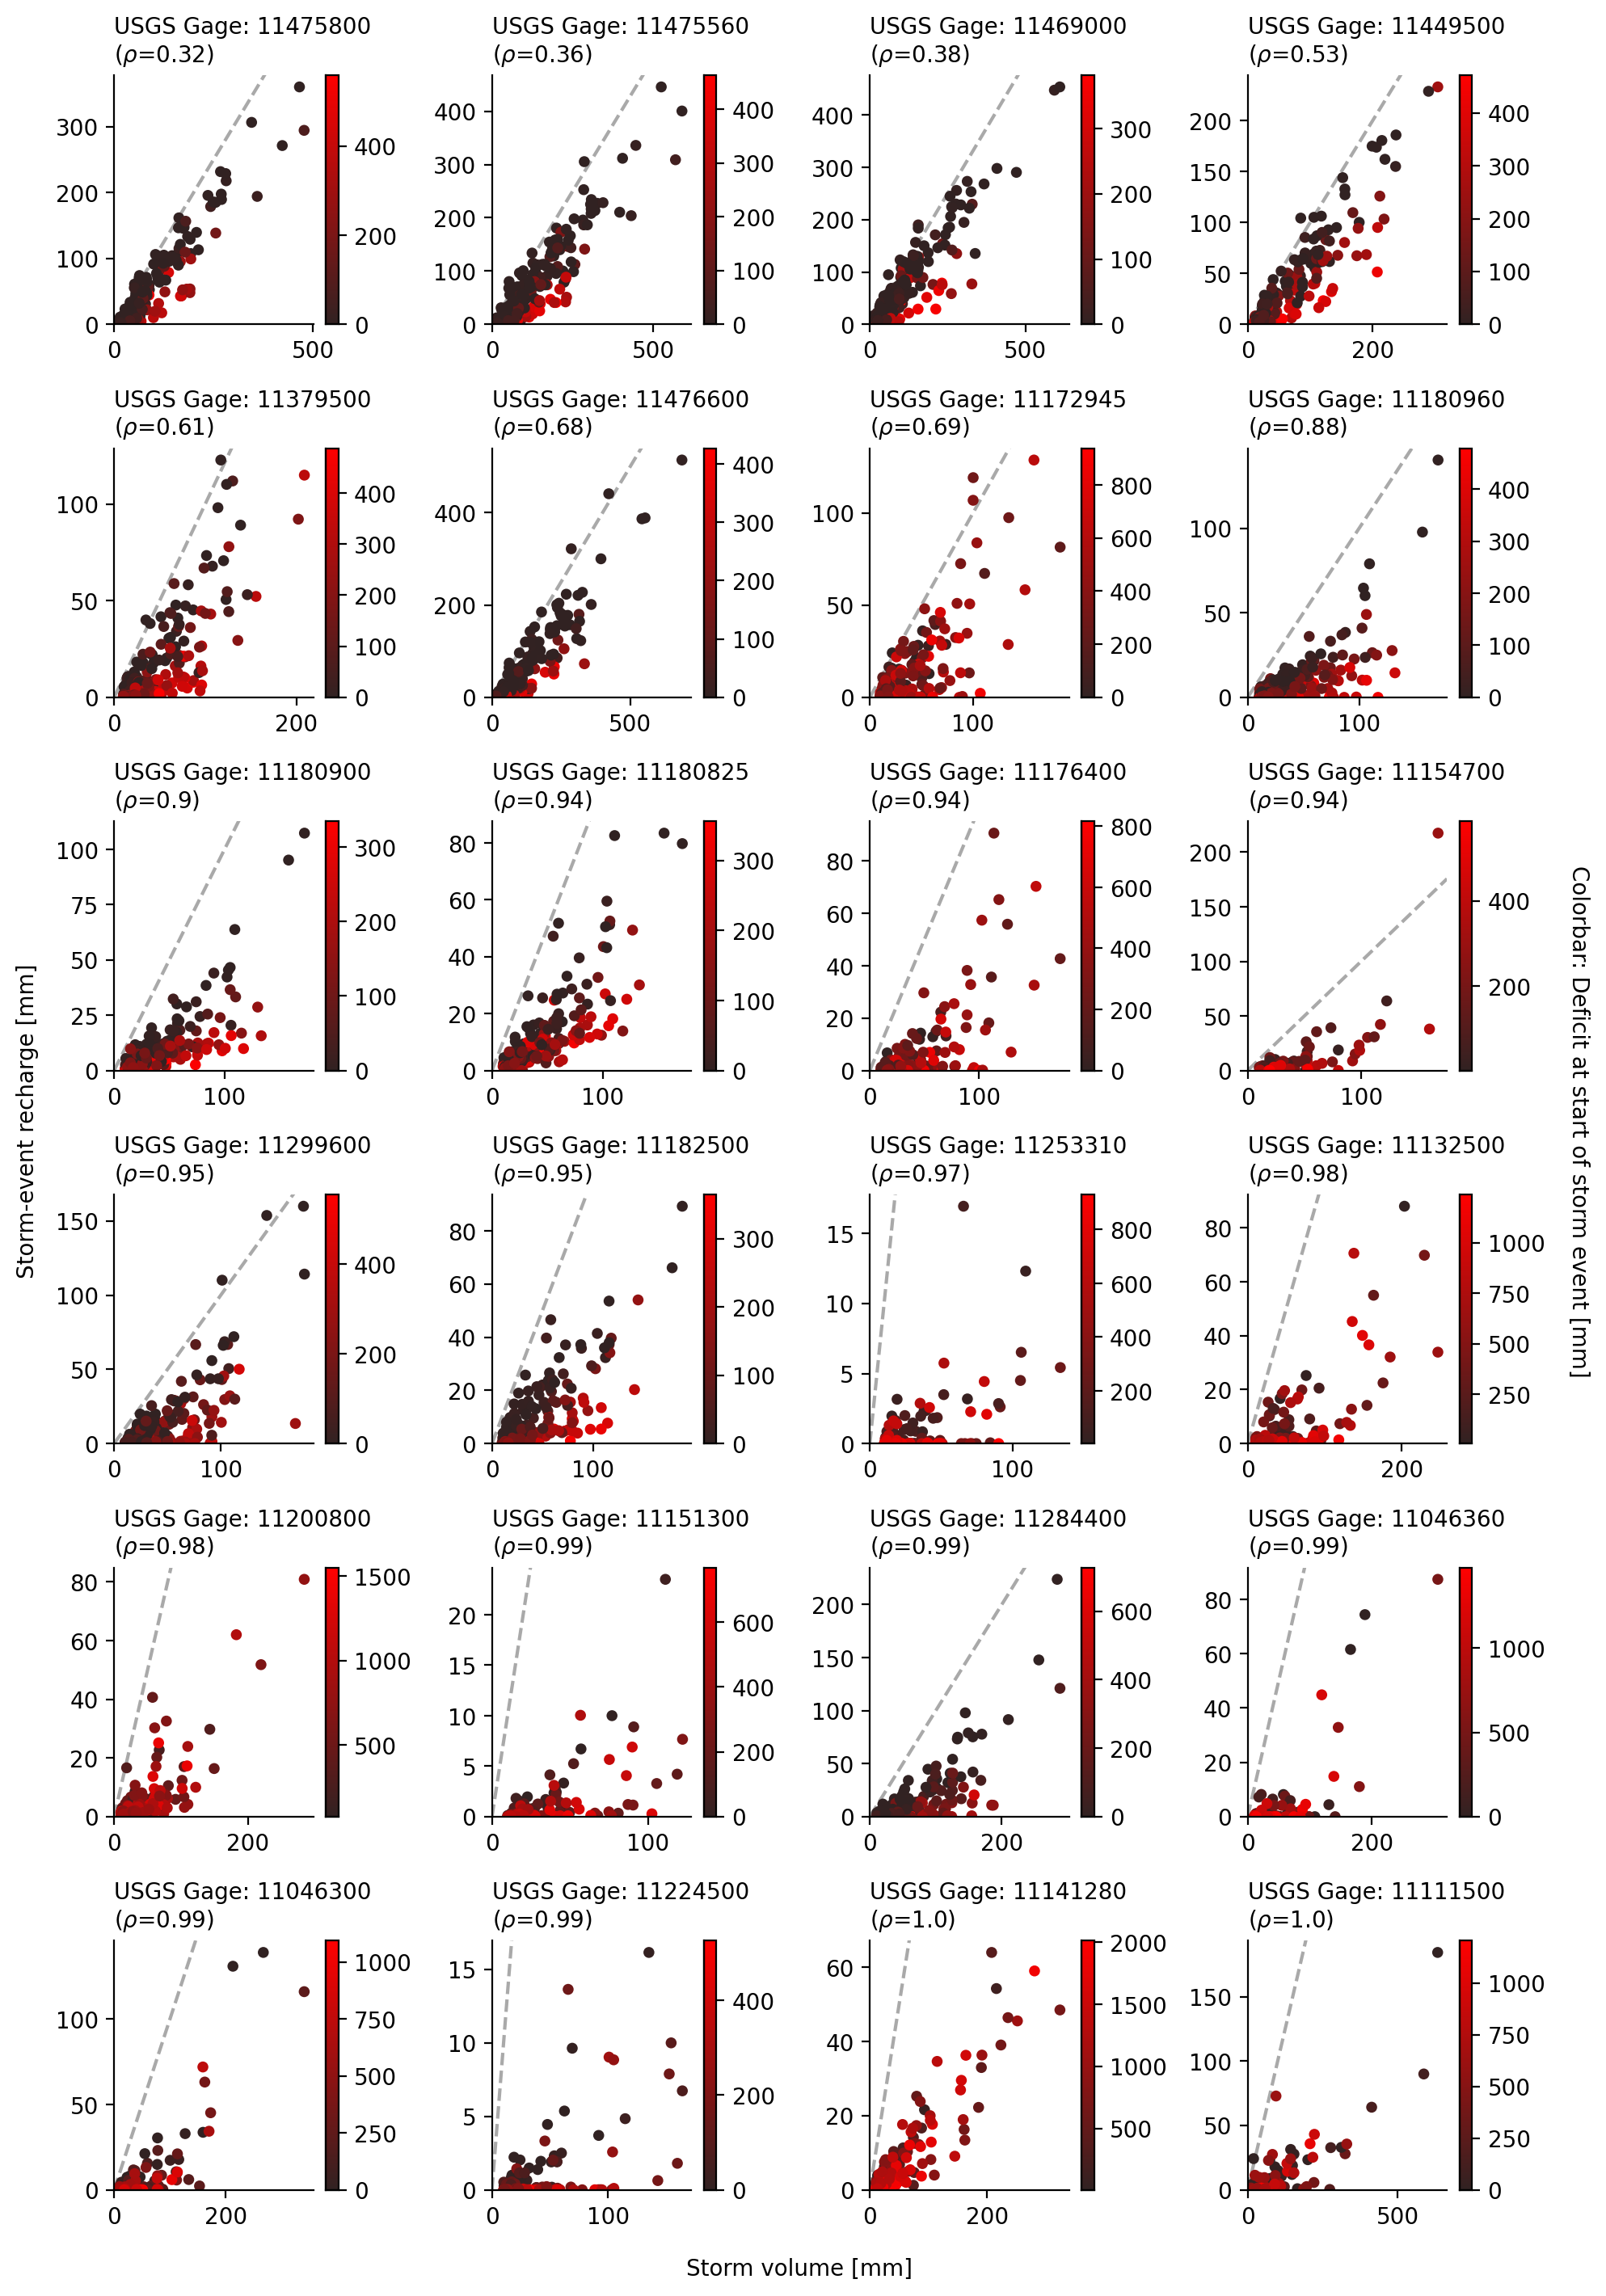

In [ ]:
# Plotting space, color map
fig, axs = plt.subplots(3,4,figsize=(10.5,7))
# fig, axs = plt.subplots(6,4,figsize=(9.5,14))
cmap = sns.dark_palette("red", as_cmap=True) # for deficit
# cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume

# Plot
for gage, ax in zip(analysis_gages,axs.ravel()): #gage_list
  # Event scale fluxes, deficit
  precip, recharge, discharge, deficit, length = storm_event_analysis(df_gages,gage)
  xdata = precip
  ydata = recharge
  colors = deficit
  # Plot data
  data = ax.scatter(xdata,ydata,s=15,c=colors,cmap=cmap)
  axcb = fig.colorbar(data)
  ax.set_xlim(left = 0)
  ax.set_ylim(bottom = 0)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Title handling
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))
  ax.set_title(title, fontsize=10, loc='left')

# Label handling
fig.text(0.5, -0.01, 'Storm volume [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge [mm]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Colorbar: Deficit at start of storm event [mm]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

**Event precipitation - deficit at start of event vs. recharge.**  Colored by storm volume.

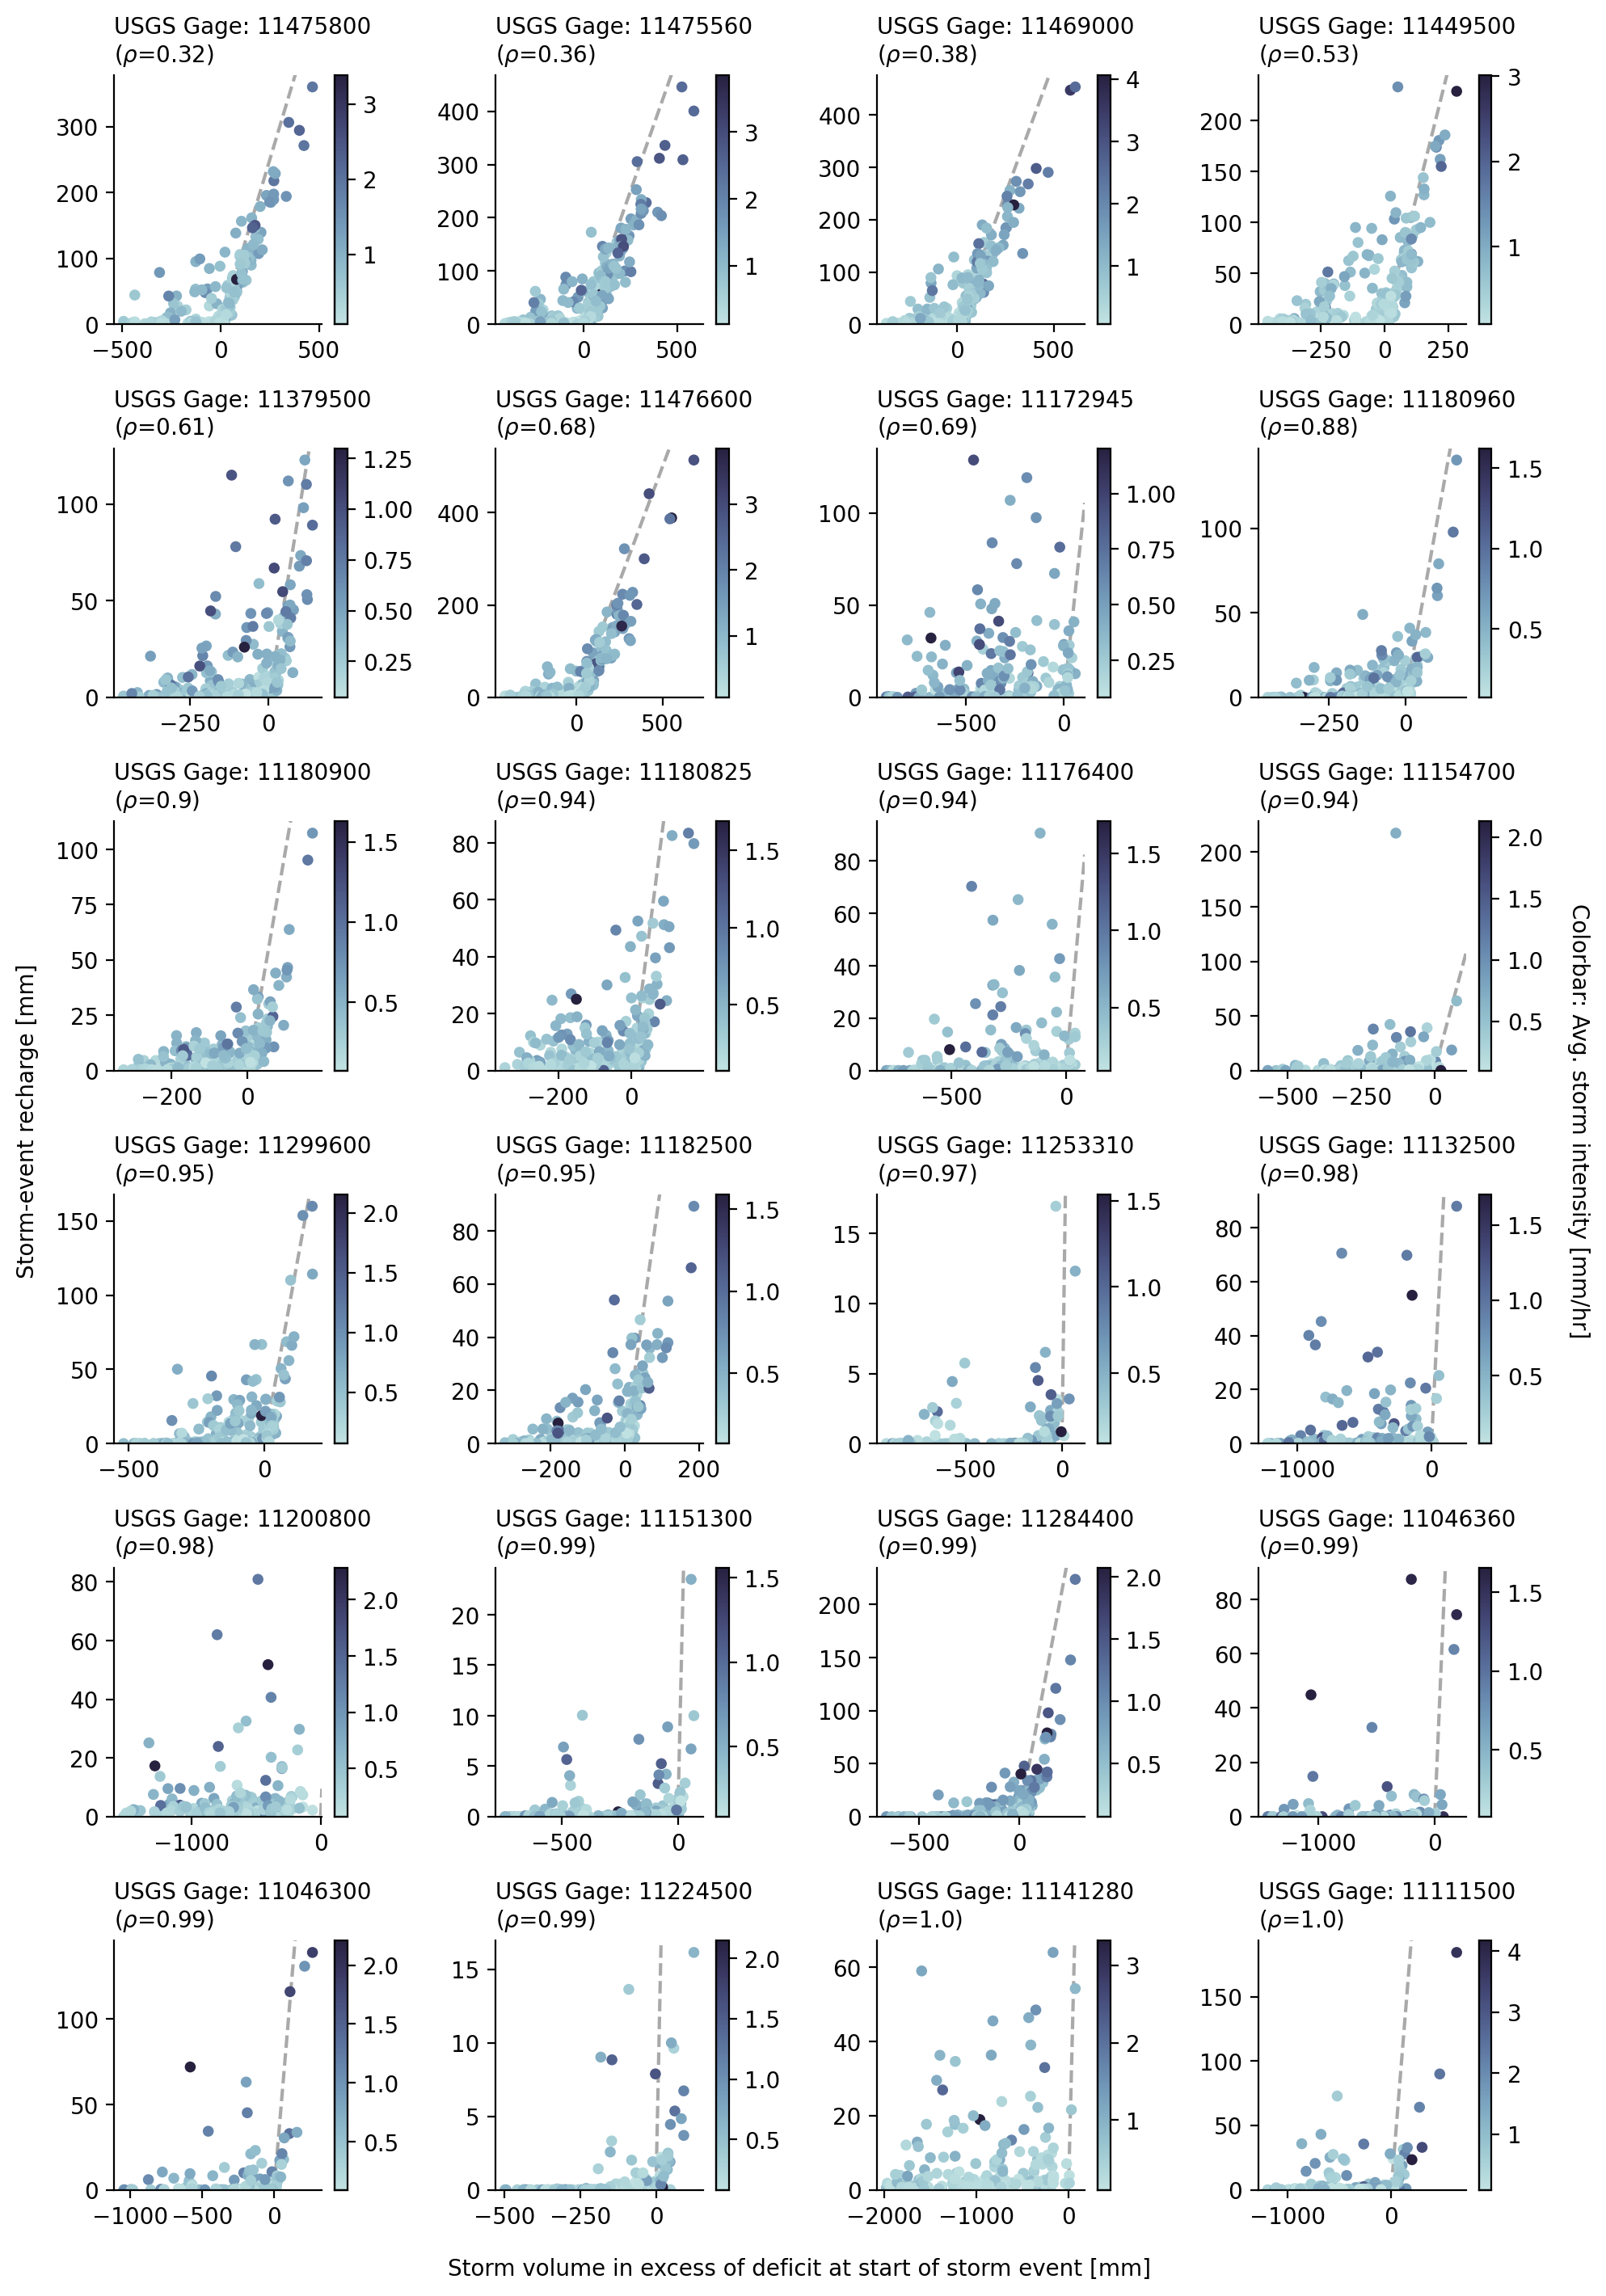

In [ ]:
# Plotting space, color map
fig, axs = plt.subplots(3,4,figsize=(10.5,7))
# fig, axs = plt.subplots(6,4,figsize=(9.5,14))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume

# Plot
for gage, ax in zip(analysis_gages,axs.ravel()): #gage_list
  # Event scale fluxes, deficit
  precip, recharge, discharge, deficit, length = storm_event_analysis(df_gages,gage)
  xdata = precip - deficit
  ydata = recharge
  colors = precip/length/24
  # Plot data
  data = ax.scatter(xdata,ydata,s=15,c=colors,cmap=cmap)
  axcb = fig.colorbar(data)
  ax.set_ylim(bottom = 0)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Title handling
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))
  ax.set_title(title, fontsize=10, loc='left')

# Label handling
fig.text(0.5, -0.01, 'Storm volume in excess of deficit at start of storm event [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge [mm]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Colorbar: Avg. storm intensity [mm/hr]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

#**References**
Hahm, W. J., Dralle, D. N., Rempe, D. M., Bryk, A. B., Thompson, S. E., Dawson, T. E., & Dietrich, W. E. (2019). Low Subsurface Water Storage Capacity Relative to Annual Rainfall Decouples Mediterranean Plant Productivity and Water Use From Rainfall Variability. Geophysical Research Letters, 46(12), 6544–6553. https://doi.org/10.1029/2019GL083294

Nash, J. E., & Sutcliffe, J. V. (1970). River flow forecasting through conceptual models part I—A discussion of principles. Journal of hydrology, 10(3), 282-290.

